In [153]:
import emcee
import pandas as pd
import numpy as np
from scipy import stats
import chainconsumer 
import matplotlib.pyplot as plt
from scipy.integrate import quad
from chainconsumer import ChainConsumer
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
%config InlineBackend.figure_format = 'svg'


In [154]:
data_pd = pd.read_csv("hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_lcparam-full.txt",sep=' ',usecols=[0,1,2,3,4,5])
z = data_pd['zhel'].astype(np.float)
dz = data_pd['dz'].astype(np.float)
muB = data_pd['mb'].astype(np.float)
dmuB = data_pd['dmb'].astype(np.float)

data = {}
data['z'] = z
data['dz'] = dz
data['muB'] = muB
data['dmuB'] = dmuB

Text(0.5, 1.0, 'Distance modulus vs redshift for Type 1a SNe ')

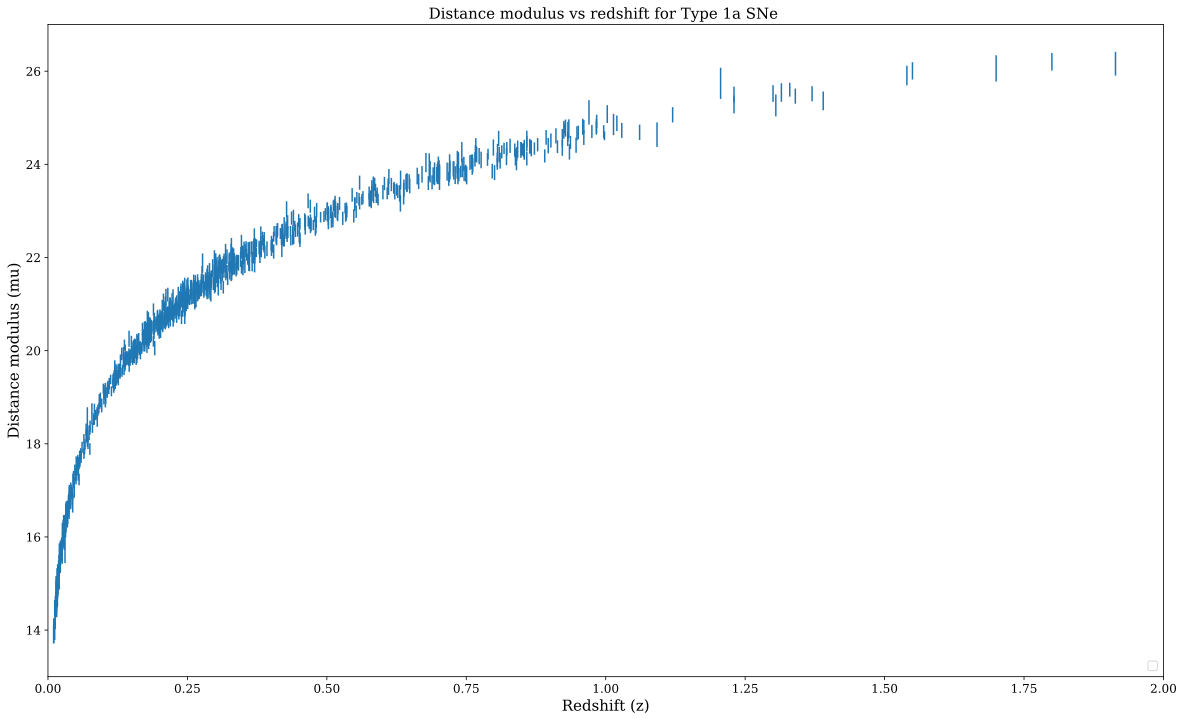

In [155]:
plt.rcParams['figure.figsize'] = [20, 12]  # set plotsize
plt.rcParams.update({'font.size': 22})       # set fontsize
fig,ax = plt.subplots(1,1)
xlim   = (0, 2)
ylim   = (13, 27)
#xlabel  = r"$z$"
#ylabel  = r"$\mu_{B}$"

ax.errorbar(x=z,y=muB,xerr=dz,yerr=dmuB,linestyle='None')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
leg = ax.legend(loc='lower right')
ax.set_xlabel('Redshift (z)')
ax.set_ylabel('Distance modulus (mu)')
ax.set_title('Distance modulus vs redshift for Type 1a SNe ')

In [156]:

def get_default_parameters(update=None):
    pars = {}
    pars['omega_m'] = 0.3
    pars['omega_L'] = 0.7
    pars['omega_K'] = 0.0
    pars['h'] = 0.72
    pars['w'] = -1.
    if update is not None:
        pars.update(update)
    return pars

def get_starting_point(name_list):
    sp = {}
    sp['omega_m'] = 0.24
    sp['omega_L'] = 0.74
    sp['omega_K'] = 0.0
    sp['h'] = 0.65
    sp['w'] = -1.    
    return np.array([sp[x] for x in name_list])

def get_latex_names(name_list):
    latex_names = {}
    latex_names['omega_m'] = '$\Omega_m$'
    latex_names['omega_L'] = '$\Omega_L$'
    latex_names['omega_K'] = '$\Omega_K$'
    latex_names['h'] = '$h$'
    latex_names['w'] = '$w$'
    
    return [latex_names[x] for x in name_list]
#constraints on the parameter values
parameter_limits={
    'omega_m' : [0., 1.],
    'omega_L' : [0., 1.],
    'omega_K' : [0., 0.], #Flat Universe
    'h'       : [.2, 1.],
    'w'     : [-1., -1.] #Lambda CDM
    }

In [157]:
def log_prior(pars, names):
    count = 0
    for name in names:
        limits = parameter_limits[name]
        low, high = limits[0], limits[1]
        if pars[name]<low or pars[name]>high:
            count+=1
    if count!=0:
        return -np.inf
    else: 
        prior = 0
        prior += ((pars['h']-0.6766)/0.0042)**2 #Planck h gaussian
        prior += ((pars['omega_m']-0.315)/0.007)**2 #Planck Omega_m gaussian
    return prior

def log_likelihood(fit_par_values, fit_par_names, flat):
    # f_gas data
    z, muB, dmuB = data['z'], data['muB'], data['dmuB']
    
    pars = get_default_parameters()
    
    for par_value, par_name in zip(fit_par_values, fit_par_names):
        pars[par_name] = par_value
    
    if not np.isfinite(log_prior(pars, fit_par_names)):
        return -np.inf
    
    else:
        log_likelihood = 0.
        
        if flat==True:
            pars['omega_L'] = 1 - pars['omega_m']
            pars['omega_K'] = 0.
        else:
            pars['omega_K'] = 1 - pars['omega_m'] - pars['omega_K']


        for  z_i, muB_i, dmuB_i in zip(z,muB,dmuB):       
            muB_model = mu_model(z_i, pars)
            log_likelihood +=((muB_i-muB_model)**2)/(dmuB_i)**2

            return -log_likelihood - log_prior(pars, fit_par_names)


In [158]:
def E_z(z, pars):
    omega_m = pars['omega_m']
    omega_L = pars['omega_L']
    omega_K = 0
    w = pars['w']
    EoS = (1+z)**(3*(1+w))
    return np.sqrt(omega_m*(1+z)**3 + omega_L*EoS + omega_K*(1+z)**2)

def one_over_E_z(z, pars):
    return 1/E_z(z, pars)

def d_l(z, pars):
    #scale hubble paramter
    H0 = pars['h']*100
    #speed of light
    c = 299792.458 # c in km/s
    #integrate for DL based on the given values of paratmers
    integral = quad(one_over_E_z, 0.01, z, args=(pars))[0]
    factor =c/(H0*(1+z))
    return factor*integral

def mu_model(z, pars):
    return 5*np.log10(d_l(z,pars))+25


In [159]:
def run_mcmc(fit_par_names, flat=True):
    pars = get_default_parameters()
    starting_point = get_starting_point(fit_par_names)
    std = 0.2*starting_point
    ndim = len(fit_par_names)
    nwalkers = 32

    p0 = emcee.utils.sample_ball(starting_point, std, size=nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[fit_par_names,flat])
    sampler.run_mcmc(p0, 20000, progress=True);
    samples = sampler.get_chain(discard=10000, flat=True)

    if flat==True and 'omega_m' in fit_par_names:
        #print('first one')

        samples_new = np.column_stack((1-samples[:,0], samples))
        
    elif flat==False and 'omega_m' in fit_par_names:
        #print('second one')
        try:
            samples_new = np.column_stack((1-samples[:,fit_par_names.index('omega_m')]-
                                           samples[:,fit_par_names.index('omega_L')], samples))
        except:
            samples_new = np.column_stack((1-samples[:,fit_par_names.index('omega_m')]-
                                           pars['omega_L'], samples))
    else:
        samples_new = samples
    return samples_new

In [160]:
fit_par_names = ['omega_m', 'h']
chain = run_mcmc(fit_par_names, flat=True)

100%|██████████| 20000/20000 [01:26<00:00, 232.42it/s]


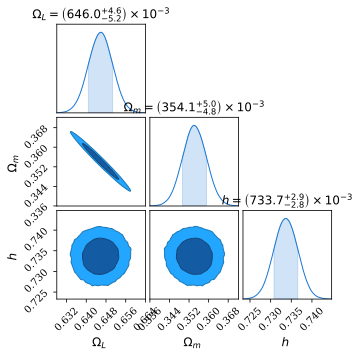

In [162]:
par_names_latex = get_latex_names(['omega_L']+fit_par_names)


c = ChainConsumer().add_chain(chain, parameters=par_names_latex).configure(statistics="max", summary=True,usetex=False)
fig = c.plotter.plot()